### Матричные факторизации

В данной работе вам предстоит познакомиться с практической стороной матричных разложений.
Работа поделена на 4 задания:
1. Вам необходимо реализовать SVD разложения используя SGD на explicit данных
2. Вам необходимо реализовать матричное разложения используя ALS на implicit данных
3. Вам необходимо реализовать матричное разложения используя BPR(pair-wise loss) на implicit данных
4. Вам необходимо реализовать матричное разложения используя WARP(list-wise loss) на implicit данных


In [1]:
import implicit
import pandas as pd
import numpy as np
import scipy.sparse as sp

from lightfm.datasets import fetch_movielens

C:\Users\Flexatroid\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


В данной работе мы будем работать с explicit датасетом movieLens, в котором представленны пары user_id movie_id и rating выставленный пользователем фильму

Скачать датасет можно по ссылке https://grouplens.org/datasets/movielens/1m/

In [2]:
ratings = pd.read_csv('data/ratings.dat', delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

In [3]:
movie_info = pd.read_csv('data/movies.dat', delimiter='::', header=None, 
        names=['movie_id', 'name', 'category'], engine='python', encoding = "ISO-8859-1")

Explicit данные

In [4]:
movie_info.head(10)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


Для того, чтобы преобразовать текущий датасет в Implicit, давайте считать что позитивная оценка это оценка >=4

In [6]:
implicit_ratings = ratings.loc[(ratings['rating'] >= 4)]

In [7]:
implicit_ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
3,1,3408,4
4,1,2355,5
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4
10,1,595,5
11,1,938,4
12,1,2398,4


Удобнее работать с sparse матричками, давайте преобразуем DataFrame в CSR матрицы

In [8]:
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
user_item_t_csr = user_item.T.tocsr()
user_item_csr = user_item.tocsr()

В качестве примера воспользуемся ALS разложением из библиотеки implicit

Зададим размерность латентного пространства равным 64, это же определяет размер user/item эмбедингов

In [9]:
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=100, calculate_training_loss=True)

В качестве loss здесь всеми любимый RMSE

In [10]:
model.fit(user_item_t_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

Построим похожие фильмы по 1 movie_id = Истории игрушек

In [11]:
movie_info.head(5)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
get_similars = lambda item_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                        for x in model.similar_items(item_id)]

Как мы видим, симилары действительно оказались симиларами.

Качество симиларов часто является хорошим способом проверить качество алгоритмов.

P.S. Если хочется поглубже разобраться в том как разные алгоритмы формируют разные латентные пространства, рекомендую загружать полученные вектора в tensorBoard и смотреть на сформированное пространство

In [13]:
get_similars(1, model)

['0    Toy Story (1995)',
 '3045    Toy Story 2 (1999)',
 "2286    Bug's Life, A (1998)",
 '584    Aladdin (1992)',
 '33    Babe (1995)',
 '360    Lion King, The (1994)',
 '2315    Babe: Pig in the City (1998)',
 '2618    Tarzan (1999)',
 '1526    Hercules (1997)',
 '1838    Mulan (1998)']

Давайте теперь построим рекомендации для юзеров

Как мы видим юзеру нравится фантастика, значит и в рекомендациях ожидаем увидеть фантастику

In [14]:
get_user_history = lambda user_id, implicit_ratings : [movie_info[movie_info["movie_id"] == x]["name"].to_string() 
                                            for x in implicit_ratings[implicit_ratings["user_id"] == user_id]["movie_id"]]

In [15]:
get_user_history(4, implicit_ratings)

['3399    Hustler, The (1961)',
 '2882    Fistful of Dollars, A (1964)',
 '1196    Alien (1979)',
 '1023    Die Hard (1988)',
 '257    Star Wars: Episode IV - A New Hope (1977)',
 '1959    Saving Private Ryan (1998)',
 '476    Jurassic Park (1993)',
 '1180    Raiders of the Lost Ark (1981)',
 '1885    Rocky (1976)',
 '1081    E.T. the Extra-Terrestrial (1982)',
 '3349    Thelma & Louise (1991)',
 '3633    Mad Max (1979)',
 '2297    King Kong (1933)',
 '1366    Jaws (1975)',
 '1183    Good, The Bad and The Ugly, The (1966)',
 '2623    Run Lola Run (Lola rennt) (1998)',
 '2878    Goldfinger (1964)',
 '1220    Terminator, The (1984)']

Получилось! 

Мы действительно порекомендовали пользователю фантастику и боевики, более того встречаются продолжения тех фильмов, которые он высоко оценил

In [16]:
get_recommendations = lambda user_id, model : [movie_info[movie_info["movie_id"] == x[0]]["name"].to_string() 
                                               for x in model.recommend(user_id, user_item_csr)]

In [17]:
get_recommendations(4, model)

['585    Terminator 2: Judgment Day (1991)',
 '1271    Indiana Jones and the Last Crusade (1989)',
 '1284    Butch Cassidy and the Sundance Kid (1969)',
 '1182    Aliens (1986)',
 '2502    Matrix, The (1999)',
 '1178    Star Wars: Episode V - The Empire Strikes Back...',
 '1884    French Connection, The (1971)',
 '847    Godfather, The (1972)',
 '3402    Close Encounters of the Third Kind (1977)',
 '1892    Rain Man (1988)']

Теперь ваша очередь реализовать самые популярные алгоритмы матричных разложений

Что будет оцениваться:
1. Корректность алгоритма
2. Качество получившихся симиларов
3. Качество итоговых рекомендаций для юзера

### Вспомогательный класс и подготовительные действия
1. Чтобы уменьшить повторение кода создадим базовый класс, от которого унаследуются последующие классы, реализующие алгоритмы матричного разложения.
3. Создадим explicit и implicit данные
2. Помимо этого немного изменим предложенные лямбда-функции для более красивого вывода.

In [90]:
from tqdm import tqdm, trange
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ratings['user_id'] -= 1
# ratings['movie_id'] -= 1
# movie_info['movie_id'] -= 1

explicit_user_item = sp.coo_matrix((ratings.rating, (ratings.user_id, ratings.movie_id)))
explicit_user_item_csr = explicit_user_item.tocsr()

implicit_ratings = ratings[ratings.rating >= 4]
users = implicit_ratings["user_id"]
movies = implicit_ratings["movie_id"]
implicit_user_item = sp.coo_matrix((np.ones_like(users), (users, movies)))
implicit_user_item_csr = implicit_user_item.tocsr()

get_similars = lambda item_id, model : pd.concat([movie_info[movie_info["movie_id"] == x[0]]
                                        for x in model.similar_items(item_id)], axis=0)

get_user_history = lambda user_id, dataset : pd.concat([movie_info[movie_info["movie_id"] == x]
                                        for x in dataset[dataset["user_id"] == user_id]["movie_id"]], axis=0)


get_recommendations = lambda user_id, model, dataset : pd.concat([movie_info[movie_info["movie_id"] == x[0]]
                                        for x in model.recommend(user_id, dataset)], axis=0)

In [96]:
class FactorizationBase:
    def __init__(self, factors=64, seed=0):
        self.factors = factors            # Number of latent factors for user / item matrices
        self.seed = seed                  # Used for random seed 
        self.iterations_history = list()  # Axis data for RMSE plot
        self.loss_history = list()        # Axis data for RMSE plot
        
        np.random.seed(self.seed)

    def show_graph(self, xlabel, ylabel):
        """
        Shows RMSE plot
        """
        fig, ax = plt.subplots()
        plt.plot(self.iterations_history, self.loss_history)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.show()
        
    def get_nonzero_indexes(self):
        """
        Returns indexes of a random non-zero element from user_item matrix 
        """
        index = np.random.randint(0, self.nonzero_count)
        return self.user_indexes[index], self.item_indexes[index]

    def prepare_fit(self, user_item):
        """
        Initializes user and item matrices, finds non-zero elements in user_item matrix
        """
        self.n_users, self.n_items = user_item.shape # User / item matrix sizes

        # latent user feature matrix and a latent item feature matrix
        self.user_mx = np.random.uniform(0.0, 1 / np.sqrt(self.factors), (self.n_users, self.factors))
        self.item_mx = np.random.uniform(0.0, 1 / np.sqrt(self.factors), (self.n_items, self.factors))
        
        # Indexes on non-zero elements in user / item matrices
        self.user_indexes, self.item_indexes = user_item.nonzero()
        self.nonzero_count = user_item.count_nonzero()


    def predict(self, i, j):
        return self.user_mx[i] @ self.item_mx[j]

    def similar_items(self, item_index, top_n=10):
        """
        Calculates a list of similar items,
        returns a list of top_n most suitable (itemid, score) tuples
        """
        distances = np.linalg.norm(self.item_mx - self.item_mx[item_index], axis=1)
        return list(zip(np.argsort(distances), list(sorted(distances))))[:top_n]
    
    def recommend(self, user_index, user_item, top_n=10):
        """
        Calculates the top_n best recommendations for a user,
        returns a list of top_n most suitable (itemid, score) tuples.
        """
        ratings = self.user_mx[user_index] @ self.item_mx.T
        nz = user_item[user_index].nonzero()[1]
        return list(filter(lambda x: x[0] not in nz, zip(np.argsort(ratings), list(sorted(ratings)))))[-top_n:]

    def calculate_rmse(self, user_item, elements=None):
        if elements is None:
            indexes = range(self.nonzero_count)
        else:    
            indexes = np.random.randint(0, self.nonzero_count, size=elements)

        def get_error(idx):
            i, j   = self.user_indexes[idx], self.item_indexes[idx]
            actual = user_item[i, j]
            return (self.predict(i, j) - actual) ** 2

        loss = np.fromiter(map(get_error , indexes), dtype=np.float64)
        rmse_loss = np.sqrt(np.mean(loss))
        return rmse_loss
    
    def calculate_auc_score(self, user_item):
        result = 0.0
        
        for user_index in range(self.n_users):
            y_pred = self.user_mx[user_index] @ self.item_mx.T
            y_true = np.zeros(self.n_items)
            y_true[user_item[user_index, :].indices] = 1
            try:
                result += roc_auc_score(y_true, y_pred)
            except ValueError: # if only one class present in y_true
                pass
        
        return result / self.n_users

### Задание 1. Не использую готовые решения, реализовать SVD разложение используя SGD на explicit данных

In [20]:
class SVD(FactorizationBase):
    def __init__(self, factors, iterations, learning_rate, matrix_reg, bias_reg):
        super().__init__(factors, 42)
        
        self.iterations = int(iterations)   # Number of iterations in learning phase
        self.learning_rate = learning_rate  # Learning rate of SGD
        self.bias_reg = bias_reg            # Regularization param for biases
        self.maxtrix_reg = matrix_reg       # Regularization param for user / item matrices

    def predict(self, i, j):
        return super().predict(i, j) + self.user_bias[i] + self.item_bias[j] + self.bias
    
    def fit(self, user_item):
        self.prepare_fit(user_item)
        
        self.bias = user_item.mean()            # Global bias
        self.user_bias = np.zeros(self.n_users) # User bias
        self.item_bias = np.zeros(self.n_items) # Item bias
        
        bar = trange(self.iterations)

        for it in bar:
            i, j = self.get_nonzero_indexes()
            error = self.predict(i, j) - user_item[i, j]
            
            self.user_bias[i] -= self.learning_rate * (error + self.bias_reg * self.user_bias[i])
            self.item_bias[j] -= self.learning_rate * (error + self.bias_reg * self.item_bias[j])

            self.user_mx[i] -= self.learning_rate * (error * self.item_mx[j] + self.maxtrix_reg * self.user_mx[i])
            self.item_mx[j] -= self.learning_rate * (error * self.user_mx[i] + self.maxtrix_reg * self.item_mx[j])

            if it % 10_000 == 0 and it > 0:
                loss = self.calculate_rmse(user_item, 250)
                self.loss_history.append(loss)
                self.iterations_history.append(it)
                bar.set_postfix_str("RMSE = {:.5f} (random {} elements)".format(loss, 250))
                
        self.show_graph("Iterations", "RMSE")

100%|█████████████████████████████| 10000000/10000000 [09:43<00:00, 17150.35it/s, RMSE = 0.64360 (random 250 elements)]


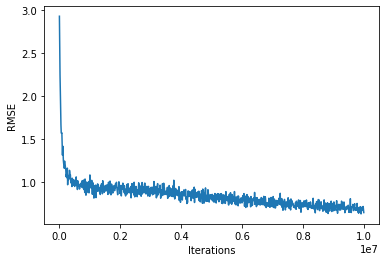

In [21]:
svd_model = SVD(iterations=1e7, factors=64, learning_rate=1e-2, matrix_reg=1e-6, bias_reg=2e-6)
svd_model.fit(explicit_user_item_csr)

In [138]:
get_similars(1, svd_model)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
2028,2097,Something Wicked This Way Comes (1983),Children's|Horror
2950,3019,Drugstore Cowboy (1989),Crime|Drama
3408,3477,Empire Records (1995),Comedy|Drama
1804,1873,"Misérables, Les (1998)",Drama
3026,3095,"Grapes of Wrath, The (1940)",Drama
942,954,Mr. Smith Goes to Washington (1939),Drama
1634,1680,Sliding Doors (1998),Drama|Romance
3634,3703,Mad Max 2 (a.k.a. The Road Warrior) (1981),Action|Sci-Fi
1831,1900,"Children of Heaven, The (Bacheha-Ye Aseman) (1...",Drama


In [139]:
get_user_history(4, ratings)

,movie_id,name,category
3399,3468,"Hustler, The (1961)",Drama
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
2882,2951,"Fistful of Dollars, A (1964)",Action|Western
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1023,1036,Die Hard (1988),Action|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1959,2028,Saving Private Ryan (1998),Action|Drama|War
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure


In [140]:
get_recommendations(4, svd_model, user_item_csr)

,movie_id,name,category
1182,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
1239,1259,Stand by Me (1986),Adventure|Comedy|Drama
1355,1376,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi
3106,3175,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi
3682,3751,Chicken Run (2000),Animation|Children's|Comedy
1022,1035,"Sound of Music, The (1965)",Musical
3443,3512,Return to Me (2000),Drama|Romance
1242,1262,"Great Escape, The (1963)",Adventure|War
33,34,Babe (1995),Children's|Comedy|Drama
262,265,Like Water for Chocolate (Como agua para choco...,Drama|Romance


### Задание 2. Не использую готовые решения, реализовать матричное разложение используя ALS на implicit данных

In [31]:
class ALS(FactorizationBase):
    def __init__(self, factors, iterations, lambda_reg, alpha):
        super().__init__(factors, 42)
        self.iterations = iterations
        self.lambda_reg = lambda_reg
        self.alpha = alpha

    def fit(self, user_item):
        self.prepare_fit(user_item)
        
        bar = trange(self.iterations)
        values = user_item.toarray()
        reg_mx = self.lambda_reg * np.eye(self.factors)
        
        for it in bar:
            items_t = self.item_mx.T
            items_t_items = items_t @ self.item_mx
            for user_index in range(self.n_users):
                preference_mx = values[user_index, :]
                confidence_mx = sp.diags(1 + self.alpha * preference_mx)
                
                tmp = items_t_items + items_t @ (confidence_mx - sp.identity(self.n_items)) @ self.item_mx + reg_mx
                self.user_mx[user_index] = np.linalg.inv(tmp) @ items_t @ confidence_mx @ preference_mx

            users_t = self.user_mx.T
            users_t_users = users_t @ self.user_mx
            for item_index in range(self.n_items):
                preference_mx = values[:, item_index]
                confidence_mx = sp.diags(1 + self.alpha * preference_mx)
                
                tmp = users_t_users + users_t @ (confidence_mx - sp.identity(self.n_users)) @ self.user_mx + reg_mx
                self.item_mx[item_index] = np.linalg.inv(tmp) @ users_t @ confidence_mx @ preference_mx

            loss = self.calculate_rmse(user_item, 10_000)
            self.loss_history.append(loss)
            self.iterations_history.append(it)
            bar.set_postfix_str("RMSE = {:.5f} (random {} elements)".format(loss, 10_000))
            
        self.show_graph("Iterations", "RMSE")

100%|████████████████████████████████████████████| 5/5 [07:45<00:00, 93.12s/it, RMSE = 0.30833 (random 10000 elements)]


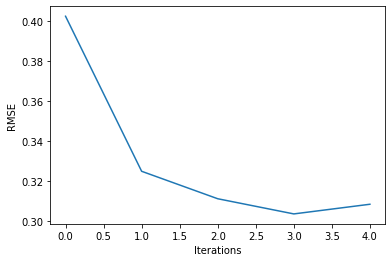

In [117]:
als_model = ALS(iterations=5, factors=64, lambda_reg=0.01, alpha=10)
als_model.fit(implicit_user_item_csr)

In [33]:
get_similars(1, als_model)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy
33,34,Babe (1995),Children's|Comedy|Drama
1245,1265,Groundhog Day (1993),Comedy|Romance
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
2252,2321,Pleasantville (1998),Comedy
2327,2396,Shakespeare in Love (1998),Comedy|Romance
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical
1854,1923,There's Something About Mary (1998),Comedy
1838,1907,Mulan (1998),Animation|Children's


In [34]:
get_user_history(4, implicit_ratings)

,movie_id,name,category
3399,3468,"Hustler, The (1961)",Drama
2882,2951,"Fistful of Dollars, A (1964)",Action|Western
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
1023,1036,Die Hard (1988),Action|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1959,2028,Saving Private Ryan (1998),Action|Drama|War
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure
1885,1954,Rocky (1976),Action|Drama
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi


In [35]:
get_recommendations(4, als_model, user_item_csr)

,movie_id,name,category
847,858,"Godfather, The (1972)",Action|Crime|Drama
1284,1304,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western
2875,2944,"Dirty Dozen, The (1967)",Action|War
453,457,"Fugitive, The (1993)",Action|Thriller
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1271,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1182,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War


### Задание 3. Не использую готовые решения, реализовать матричное разложение BPR на implicit данных

In [124]:
class BPR(FactorizationBase):
    def __init__(self, iterations, factors, learning_rate, lambda_reg):
        super().__init__(factors, 42)
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        
        self.positives = {}
        self.negatives = {}

    def get_negative(self, user_index, i):
        return np.random.choice(self.negatives[user_index])
        
    def fit(self, user_item):     
        self.prepare_fit(user_item)
        
        step = lambda x, d, m: self.learning_rate * ((np.exp(-x) / (1 + np.exp(-x))) * d - self.lambda_reg * m)
        bar = trange(self.iterations)
        values = user_item.toarray()
        items_range = np.arange(self.n_items)
        users_range = np.unique(self.user_indexes)

        for user_index in np.arange(self.n_users):
            self.positives[user_index] = items_range[values[user_index] >  0]
            self.negatives[user_index] = items_range[values[user_index] == 0]
        
        for it in bar:
            bar.set_description('Epoch {}'.format(it + 1))
            
            for user_index in users_range:
                for i in self.positives[user_index]:
                    j = self.get_negative(user_index, i)
                    
                    positive_item = self.item_mx[i]
                    negative_item = self.item_mx[j]
                    
                    x = self.user_mx[user_index] @ (positive_item - negative_item).T
                    
                    self.user_mx[user_index] += step(x, positive_item - negative_item, self.user_mx[user_index])
                    self.item_mx[i] += step(x, self.user_mx[user_index], positive_item)
                    self.item_mx[j] += step(x, -self.user_mx[user_index], negative_item)
            
            auc = self.calculate_auc_score(user_item)
            self.loss_history.append(auc)
            self.iterations_history.append(it)
            bar.set_postfix_str("AUC = {:.5f}".format(auc))
        
        self.show_graph("Epoches", "AUC")

Epoch 150: 100%|████████████████████████████████████████████████████| 150/150 [1:50:54<00:00, 44.36s/it, AUC = 0.98045]


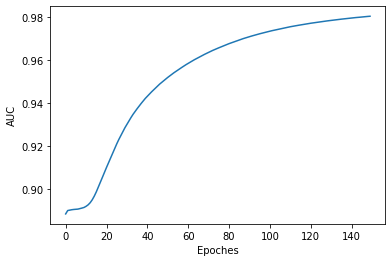

In [103]:
bpr_model = BPR(iterations=150, factors=64, learning_rate=1e-2, lambda_reg=1e-4)
bpr_model.fit(implicit_user_item_csr)

In [104]:
get_similars(1, bpr_model)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
33,34,Babe (1995),Children's|Comedy|Drama
584,588,Aladdin (1992),Animation|Children's|Comedy|Musical
2692,2761,"Iron Giant, The (1999)",Animation|Children's
2252,2321,Pleasantville (1998),Comedy
1854,1923,There's Something About Mary (1998),Comedy
1595,1641,"Full Monty, The (1997)",Comedy
1726,1784,As Good As It Gets (1997),Comedy|Drama


In [105]:
get_recommendations(4, bpr_model, user_item_csr)

,movie_id,name,category
1182,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
108,110,Braveheart (1995),Action|Drama|War
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
1284,1304,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
847,858,"Godfather, The (1972)",Action|Crime|Drama
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War


### Задание 4. Не использую готовые решения, реализовать матричное разложение WARP на implicit данных

In [137]:
class WARP(BPR):
    def __init__(self, iterations, factors, learning_rate, lambda_reg, sample_size): 
        super().__init__(iterations, factors, learning_rate, lambda_reg)
        self.sample_size = sample_size
    
    def get_negative(self, user_index, i):
        score_i = self.user_mx[user_index] @ self.item_mx[i]
        j, score_j = None, None
        for n in range(1, self.sample_size):
            j = np.random.choice(self.negatives[user_index])
            score_j = self.user_mx[user_index] @ self.item_mx[j]
            if score_j - 1 > score_i:
                return j
        
        return j


Epoch 80: 100%|██████████████████████████████████████████████████████| 80/80 [4:34:44<00:00, 206.05s/it, AUC = 0.98021]


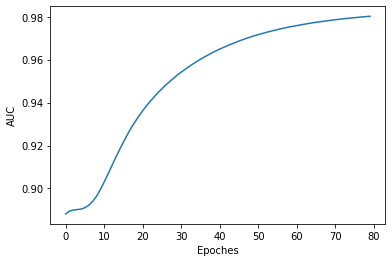

In [128]:
warp_model = WARP(iterations=80, factors=64, learning_rate=1e-2, lambda_reg=1e-4, sample_size=20)
warp_model.fit(implicit_user_item_csr)

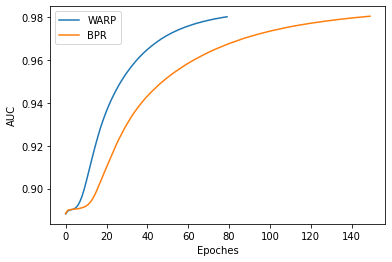

In [129]:
fig, ax = plt.subplots()
plt.plot(warp_model.iterations_history, warp_model.loss_history, label="WARP")
plt.plot(bpr_model.iterations_history, bpr_model.loss_history, label="BPR")
ax.set_xlabel("Epoches")
ax.set_ylabel("AUC")
plt.legend()
plt.show()

In [135]:
get_similars(1, warp_model)

,movie_id,name,category
0,1,Toy Story (1995),Animation|Children's|Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy
2286,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
2692,2761,"Iron Giant, The (1999)",Animation|Children's
2252,2321,Pleasantville (1998),Comedy
2225,2294,Antz (1998),Animation|Children's
1595,1641,"Full Monty, The (1997)",Comedy
2290,2359,Waking Ned Devine (1998),Comedy
1726,1784,As Good As It Gets (1997),Comedy|Drama
38,39,Clueless (1995),Comedy|Romance


In [136]:
get_recommendations(4, warp_model, user_item_csr)

,movie_id,name,category
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
1271,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
907,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
847,858,"Godfather, The (1972)",Action|Crime|Drama
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
